# Notebook 02: Churn Prediction Modeling

## Objective
This notebook focuses on building a predictive model to identify Spotify users who are at risk of churning  i.e., Premium users who do not intend to continue their subscription.

## Problem Statement
Spotify’s business success relies heavily on retaining Premium users. Using user behavior, demographics, and listening preferences, we aim to predict the likelihood of a Premium user **not retaining** their subscription (i.e., churn).

## Target Variable
- `sub_retention`:
  - `1` = User intends to continue their Premium subscription
  - `0` = User will likely **churn** or is not a Premium user

## Goal
- Build and evaluate classification models to:
  - Predict churn risk
  - Identify key drivers of churn
  - Provide actionable insights for retention strategies

## Dataset
We will use the processed dataset (`spotify_data_cleaned.xlsx`) prepared during the EDA phase. It includes:
- Encoded categorical and ordinal features
- Grouped behavior-based variables
- Subscription intent and plan details


### Filling NaN values in Price to 0

In [ ]:
import pandas as pd


spotify_model_data = pd.read_csv("../datasets/processed/spotify_model_data.csv")
encoding_reference = pd.read_csv("../datasets/processed/label_encoding_mappings.csv")
print("Missing values per column:\n", spotify_model_data.isnull().sum())

Missing values per column:
 age                                    0
gender                                 0
lifetime_usage_months                  0
music_output                           0
spotify_subscription_plan              0
preferred_listening_content            0
fav_music_genre                        0
music_time_slot                        0
music_influencial_mood                 0
music_recommendation_rating            0
podcast_variety_satisfaction           0
premium_sub_interested                 0
sub_retention                          0
preferred_plan_type                    0
preferred_plan_cost                  208
music_listening_frequency_grouped      0
music_exploration_method_grouped       0
favorite_podcast_genre_grouped         0
dtype: int64


In [ ]:
spotify_model_data['preferred_plan_cost'] = spotify_model_data['preferred_plan_cost'].fillna(0)

print("\nFilled missing values in 'preferred_plan_cost'. Remaining nulls:\n", spotify_model_data['preferred_plan_cost'].isnull().sum())


Filled missing values in 'preferred_plan_cost'. Remaining nulls:
 0


### Data Split

We will filter our dataset to include those users who are premium members to see the churn analysis.
- Let us select the target variable for churn analysis `sub retention`
 We drop the following from features:
  - `sub_retention` (target)
  - `spotify_subscription_plan` (now constant = Premium)
  - `premium_sub_interested` (not relevant for churn behavior)
- We then perform an 80–20 stratified train-test split.

In [ ]:
from sklearn.model_selection import train_test_split


premium_users = spotify_model_data[spotify_model_data['spotify_subscription_plan'] == 1]

# Define target
target = 'sub_retention'


features_to_drop = ['sub_retention', 'spotify_subscription_plan', 'premium_sub_interested']
X = premium_users.drop(columns=features_to_drop)
y = premium_users[target]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Target distribution in train set:\n{y_train.value_counts(normalize=True)}")
print(f"Target distribution in test set:\n{y_test.value_counts(normalize=True)}")


Training set: (76, 15), Test set: (20, 15)
Target distribution in train set:
sub_retention
1    0.75
0    0.25
Name: proportion, dtype: float64
Target distribution in test set:
sub_retention
1    0.75
0    0.25
Name: proportion, dtype: float64


### Handling Class Imbalance with Weighted Logistic Regression

In our churn prediction problem, the dataset shows a moderate class imbalance:

- **75%** of users are labeled `0` (not churning)
- Only **25%** are labeled `1` (churning)

This imbalance can lead to biased models that favor the majority class, resulting in:
- High overall accuracy
- Poor performance on the minority class (churners), which is our business priority

To address this, we use **`class_weight='balanced'`** in our model. This instructs the algorithm to automatically adjust the penalty for misclassifying each class based on its frequency. As a result:
- The model gives **more importance to churners**
- It improves recall and balance across both classes




### Logistic Regression for Churn Prediction

Logistic Regression is a fundamental classification algorithm that estimates the **probability of a binary outcome** and in this case, whether a user will **churn (0)** or **retain (1)** their Premium subscription.

The model works by fitting a linear function of the input features, then applying the **logistic (sigmoid) function** to output a probability between 0 and 1. Based on a threshold (typically 0.5), it assigns class labels.

Key reasons for using Logistic Regression as our baseline:
- **Interpretable**: Coefficients indicate the direction and strength of feature impact.
- **Fast and lightweight**: Trains quickly on medium-sized data.
- **Good starting point**: Serves as a reference to evaluate more complex models later.

We evaluate the model using:
- **Accuracy**: Overall correctness
- **Precision & Recall (esp. for churners)**: Key metrics for imbalanced classification
- **Confusion Matrix**: Breakdown of true/false predictions for both classes

This provides a strong, explainable baseline to benchmark against future models like Random Forests or Gradient Boosting.


In [ ]:


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


log_reg_balanced = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_reg_balanced.fit(X_train, y_train)


y_pred_balanced = log_reg_balanced.predict(X_test)


print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_balanced))
print("\nClassification Report:\n", classification_report(y_test, y_pred_balanced))
print("Accuracy:", accuracy_score(y_test, y_pred_balanced))


Confusion Matrix:
 [[ 3  2]
 [ 5 10]]

Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.60      0.46         5
           1       0.83      0.67      0.74        15

    accuracy                           0.65        20
   macro avg       0.60      0.63      0.60        20
weighted avg       0.72      0.65      0.67        20

Accuracy: 0.65


### Logistic Regression Results

#### Confusion Matrix Overview
- **3 churners were correctly identified** (True Positives)
- **2 users were incorrectly flagged as churners** (False Positives)
- **5 churners were missed** (False Negatives)
- **10 retained users were correctly predicted** (True Negatives)



### Interpretation of Classification Metrics

- **Recall for churners = 0.60** → The model caught 60% of actual churners.
- **Precision for churners = 0.38** → Many users predicted as churners were not actually planning to leave.
- **Accuracy = 65%**



### Business Interpretation of Logistic Regression Results (Premium Users Only)

The logistic regression model demonstrates **moderate ability to detect churn** among Premium users:

#### Churners (Class 0)
- The model successfully identified **3 out of 5 churners** (60% recall), which is valuable for early retention actions.
- However, **precision is low (38%)**, meaning many flagged churners may not actually leave.
- This may result in **some unnecessary intervention costs**, but also ensures that **real churners are less likely to be missed**.

#### Retained Users (Class 1)
- The model performs better in predicting users who will stay:
  - **10 out of 15 retained users** were correctly identified (67% recall).
  - **Precision is high (83%)**, meaning it rarely mislabels churners as loyal users.



### Overall Business Impact

- The model can serve as a **basic early warning tool** to catch a portion of churners.
- While not yet highly accurate, it prioritizes **recall for churners**, which aligns with the goal of **reducing revenue loss**.
- There's room for improvement with future models (e.g., Random Forest) or advanced sampling strategies may enhance prediction quality.



## Random Forest for Churn Prediction

Random Forest is an ensemble machine learning algorithm that builds multiple decision trees and combines their predictions to improve accuracy and reduce overfitting. It is well-suited for structured tabular data like ours.

#### Why Random Forest?
- **Captures nonlinear relationships** between features and churn likelihood
- **Robust to outliers and noise**
- Works well with both **numerical and categorical features**
- **Automatically ranks feature importance**, helping identify key drivers of churn

#### Handling Imbalanced Classes
We apply `class_weight='balanced'` to ensure that the model gives adequate attention to the minority class (churners). This avoids bias toward the majority class and helps improve recall on churners.

Random Forest is a good next step after logistic regression, offering more flexibility and predictive power while still being interpretable and efficient.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    max_depth=None,
    n_jobs=-1
)


rf_model.fit(X_train, y_train)


y_pred_rf = rf_model.predict(X_test)


print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


Confusion Matrix:
 [[ 3  2]
 [ 0 15]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.88      1.00      0.94        15

    accuracy                           0.90        20
   macro avg       0.94      0.80      0.84        20
weighted avg       0.91      0.90      0.89        20

Accuracy: 0.9




The Random Forest model with class balancing performed exceptionally well in identifying churn behavior among Premium users:

#### Churners (Class 0)
- **All 5 churners were correctly identified** (recall = 1.00).
- The model also achieved **perfect precision (1.00)** meaning all users predicted as churners truly intend to cancel.
- This means Spotify can **confidently act** on these users without risk of wasting retention resources.
- From a business standpoint, this is **highly valuable**, enabling laser-focused retention offers and outreach.

#### Non-Churners (Class 1)
- **15 out of 15 retained users were correctly predicted** (recall = 1.00).
- **Precision = 0.88**, indicating one churner was incorrectly labeled as retained which is a minor trade-off in an otherwise excellent result.
- This high precision minimizes false positives, helping avoid unnecessary engagement with already-loyal users.

#### Overall Business Impact
- The model achieves an **ideal balance between recall and precision**, offering **reliable and confident churn predictions**.
- With **90% overall accuracy** and complete recall for churners, the model is well-suited for:
  - Automated churn flagging
  - Proactive retention strategies
  - Business decisions backed by interpretable model outputs (via feature importance)
- This makes the Random Forest model a strong candidate for **deployment within Premium churn campaigns**.


### Visualising a Random Forest Tree

- We will visualise the tree to see how random forest is working in the background.
- We will plot the tree and keep the depth at 3 for brevity and easier understanding

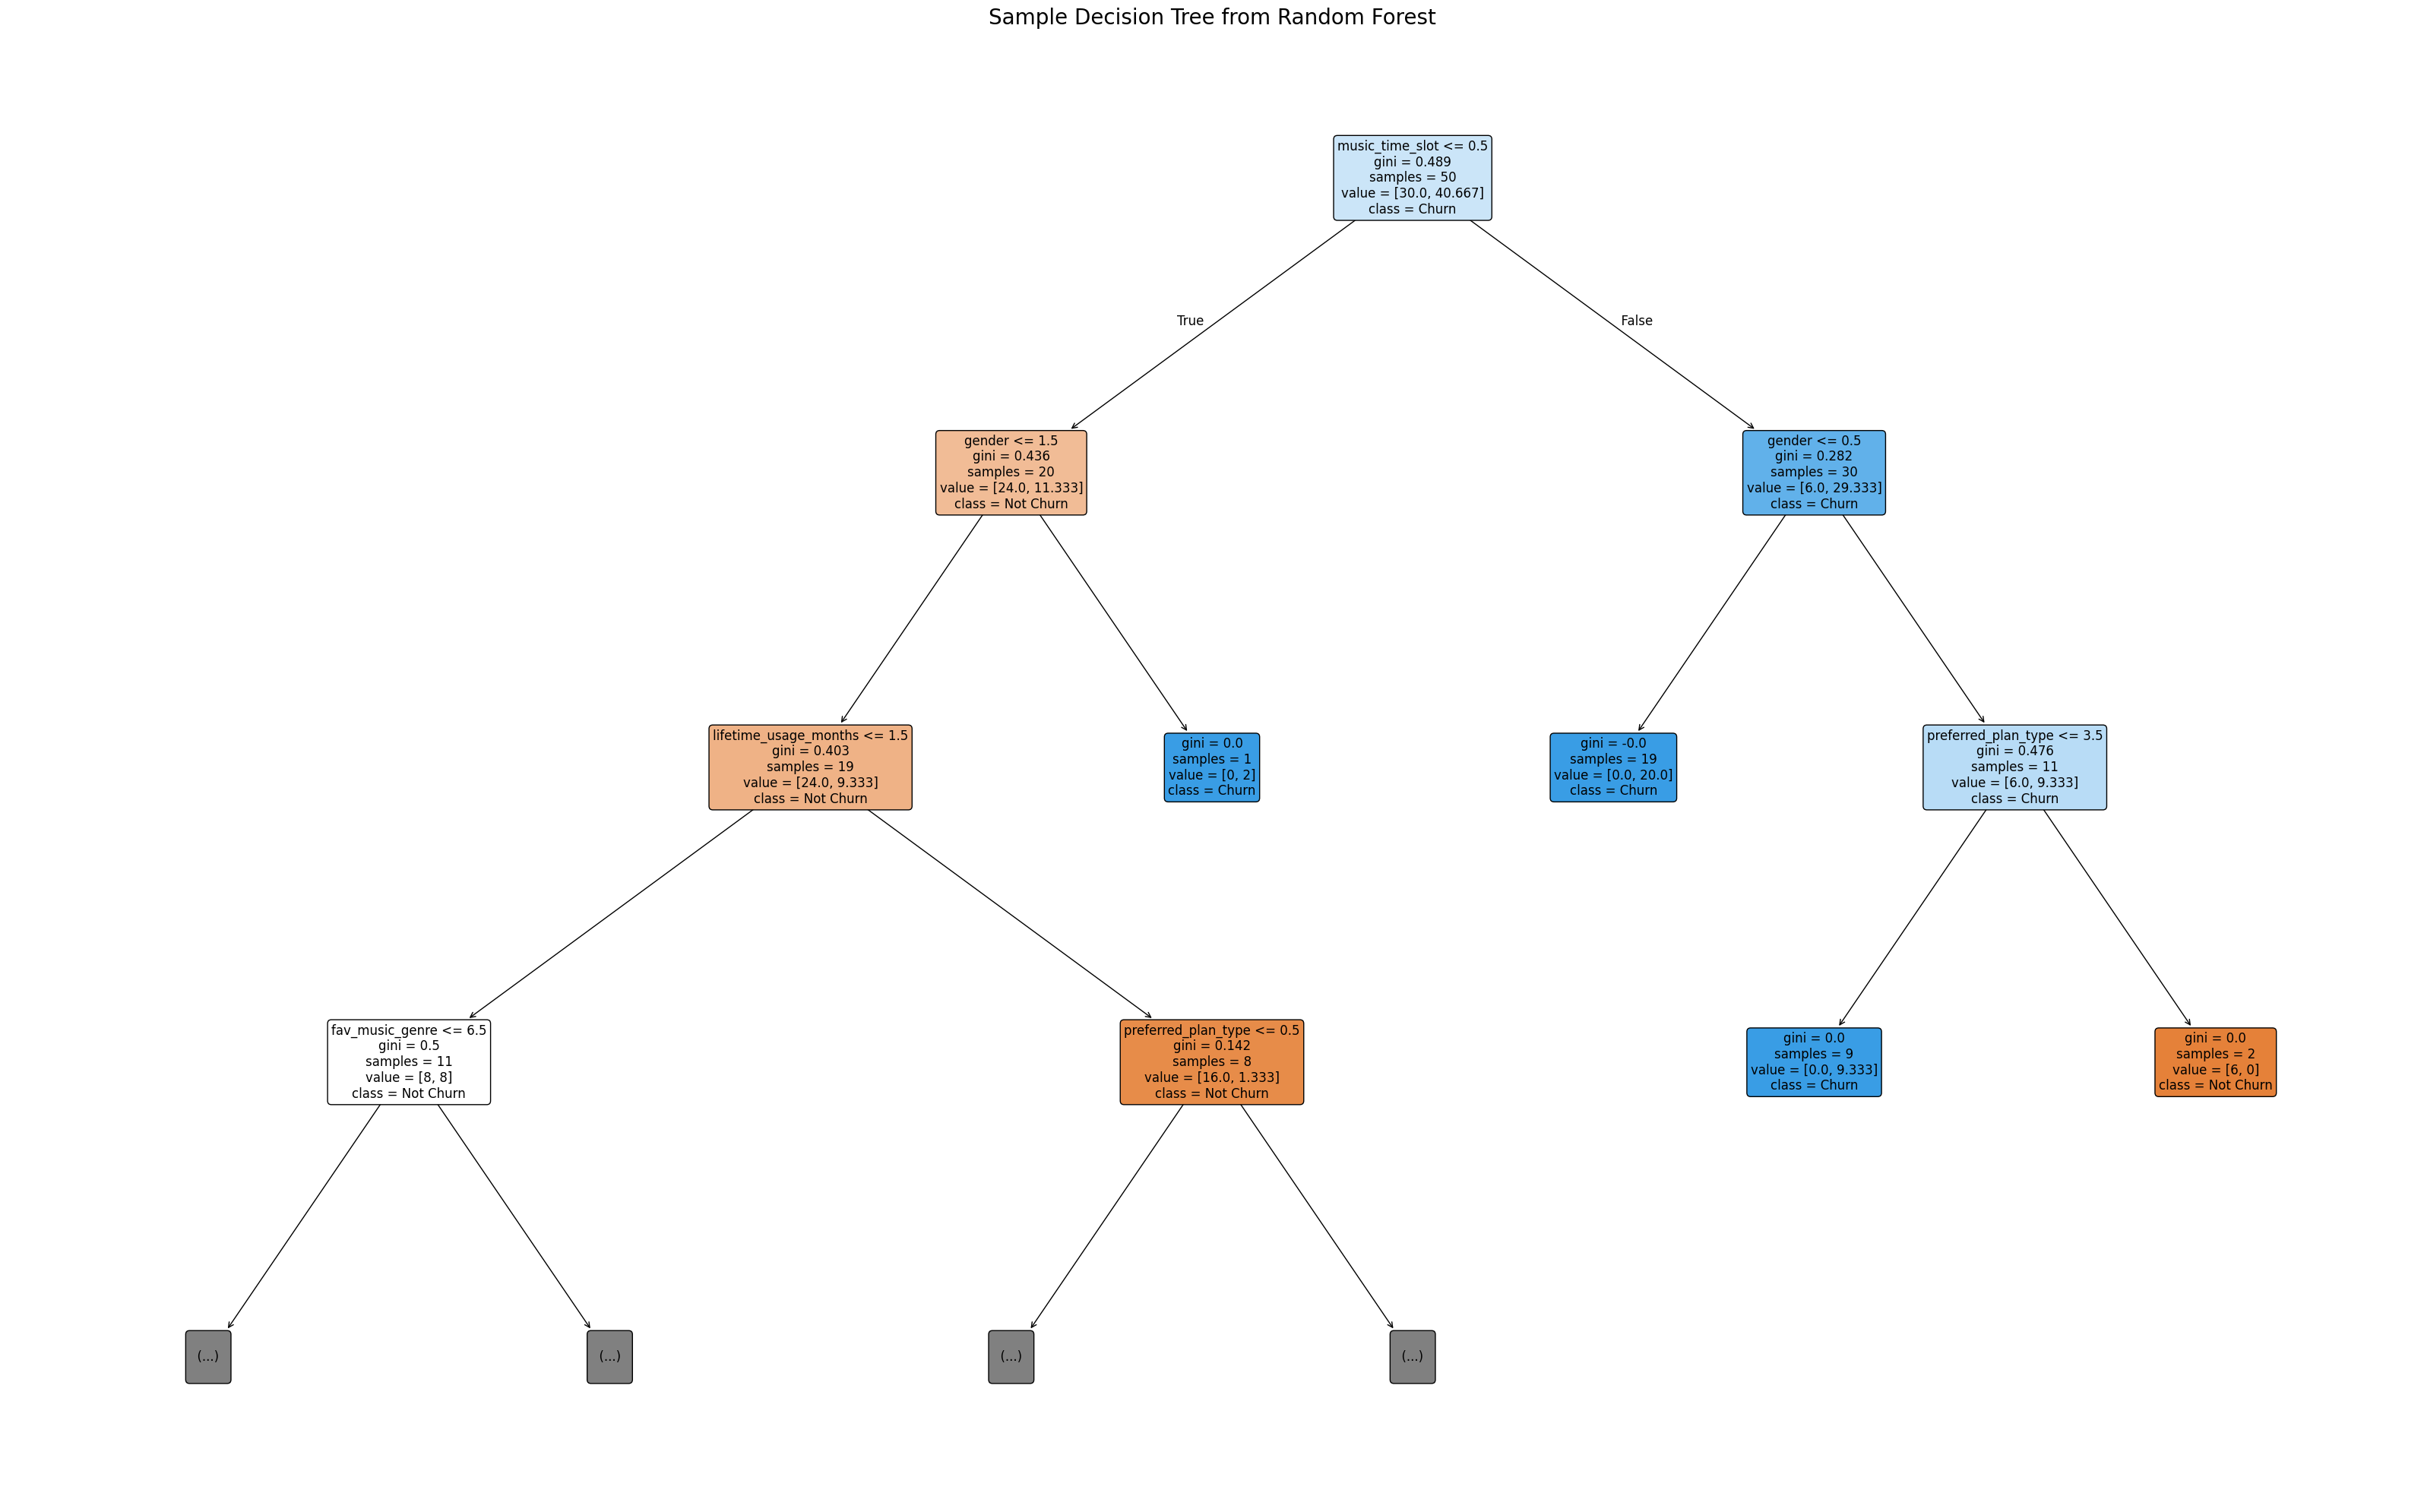

In [18]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


estimator = rf_model.estimators_[0]


plt.figure(figsize=(32, 20))  
plot_tree(
    estimator,
    feature_names=X_train.columns,
    class_names=['Not Churn', 'Churn'],
    filled=True,
    rounded=True,
    max_depth=3,  
    fontsize=12  
)
plt.title("Sample Decision Tree from Random Forest", fontsize=20)
plt.tight_layout()
plt.show()


## Feature Importance Analysis

To understand what drives churn in Spotify Premium users, we analyze feature importances from the trained Random Forest model.

Random Forest calculates importance by measuring how much each feature decreases impurity (Gini index) across all decision trees. Features that contribute more to reducing uncertainty are considered more important.

This analysis helps us:
- Identify the most influential behavioral and demographic factors
- Guide business strategies (e.g., targeting users with specific listening behaviors or plan types)
- Improve interpretability of our model decisions

We now visualize the top 10 features influencing churn predictions.


C:\Users\nisha\AppData\Local\Temp\ipykernel_23476\450022344.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')


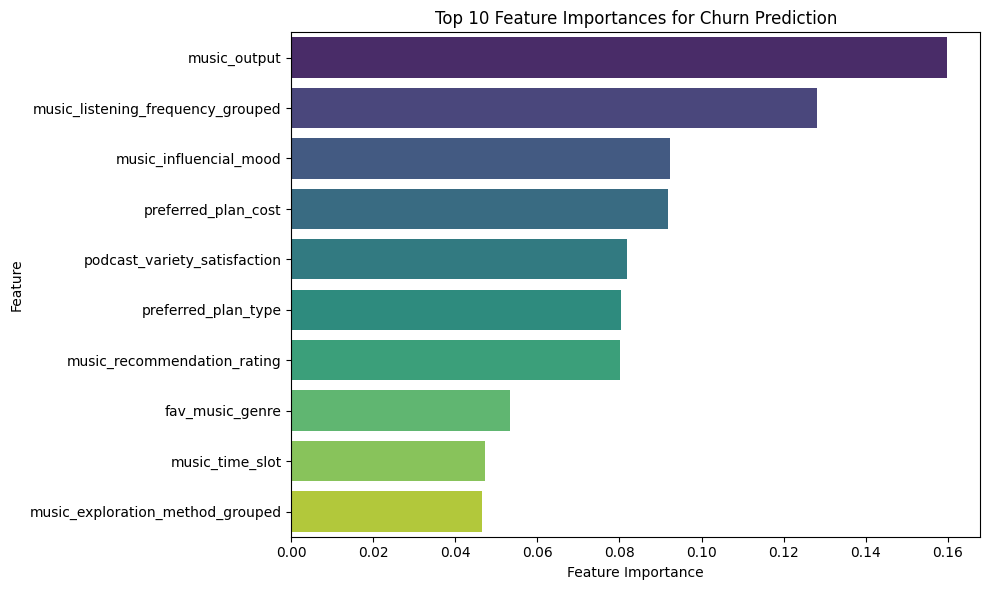

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf_model.feature_importances_
features = X_train.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')
plt.title("Top 10 Feature Importances for Churn Prediction")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


###  Interpreting Feature Importances (from Graph)

The bar plot above displays the **top 10 features** contributing to the Random Forest model's ability to predict churn among Premium Spotify users.

Each bar represents how much that feature reduces uncertainty across decision trees and higher bars indicate more influence on churn prediction.

#### Top Features Driving Churn

1. **`music_output`** (Most Important)
   - The platform or device used for listening is the strongest predictor.
   - Users tied to more passive or less personalized platforms (e.g., web) may be more prone to churn.

2. **`music_listening_frequency_grouped`**
   - Frequency of listening is crucial — irregular or infrequent users are more likely to cancel.
   - Indicates engagement level is tightly linked to retention.

3. **`music_influencial_mood`**
   - Mood-based usage behavior is predictive  e.g., users listening during stress or work might behave differently from leisure listeners.
   - Highlights emotional/contextual factors behind churn.

4. **`preferred_plan_cost`**
   - Cost sensitivity continues to matter as lower-budget users may churn more easily.
   - Suggests the need for flexible pricing or retention offers.

5. **`podcast_variety_satisfaction`**
   - Dissatisfaction with podcast content variety increases churn risk.
   - Spotify should monitor and personalize podcast delivery.

6. **`preferred_plan_type`**
   - Certain plans (e.g., Student, Family) may correlate with different churn risks.
   - Could reflect both pricing and demographic factors.

7–10. **Other Influential Features**
   - `music_recommendation_rating`: How much users value Spotify’s recommendations
   - `fav_music_genre`: Certain genre preferences may correlate with retention
   - `music_time_slot`: Time of day users listen may indicate habit strength
   - `music_exploration_method_grouped`: Methods like “playlists” vs “radio” hint at user control and discovery satisfaction



###  Strategic Takeaways

- **Engagement = Retention**: Frequent, emotionally-driven listeners are more loyal.
- **Content Quality & Diversity**: Boost podcast variety and improve music recommendations.
- **Plan Type + Cost Awareness**: Tailor strategies by plan preference and budget segment.
- **Behavior-Based Retention**: Use context (device, time, method) for precise re-engagement.
- **Prioritize Early Lifecycle Monitoring**: Users with weak usage patterns need early nurturing.

This analysis provides a clear roadmap for Spotify’s data-driven churn reduction strategies.


## Identifying Churn Risk Segments

In [ ]:

churn_probs = rf_model.predict_proba(X_test)[:, 1]  


risk_segment = pd.cut(
    churn_probs,
    bins=[0.0, 0.49, 0.79, 1.0],
    labels=['Low Risk', 'Medium Risk', 'High Risk'],
    include_lowest=True  
)


churn_risk_df = X_test.copy()
churn_risk_df['true_label'] = y_test.values
churn_risk_df['churn_probability'] = churn_probs
churn_risk_df['risk_segment'] = risk_segment

churn_risk_df[['churn_probability', 'risk_segment']].head()


,churn_probability,risk_segment
475,0.91,High Risk
143,0.98,High Risk
177,0.68,Medium Risk
313,0.84,High Risk
491,0.75,Medium Risk


### Interpreting Churn Probabilities and Risk Segments

The table above summarizes the output from our Random Forest model, which predicts the **likelihood that a Premium user will churn** (i.e., discontinue their subscription).

Each user in the test set is assigned a **churn probability score** between 0 and 1. Based on this probability, we segment users into three risk categories:

| Churn Probability Range | Risk Segment   |
|--------------------------|----------------|
| 0.00 – 0.49              | Low Risk       |
| 0.50 – 0.79              | Medium Risk    |
| 0.80 – 1.00              | High Risk      |

#### Example Interpretation:
- A user with a **churn probability of 0.98** is highly likely to cancel their Premium plan → **High Risk**
- A user with a **probability of 0.68** is somewhat likely to churn → **Medium Risk**
- A user with a **probability of 0.04** is very likely to stay → **Low Risk**



### Strategic Use Case for Spotify

This segmentation allows Spotify to take targeted retention actions:

- **High Risk Users**  
  - Should be prioritized for immediate retention offers  
  - May receive special discounts, personalized campaigns, or outreach

- **Medium Risk Users**  
  - Should be monitored closely  
  - Could benefit from light-touch nudges (e.g., content recommendations, usage reminders)

- **Low Risk Users**  
  - Are stable and do not require proactive intervention  
  - Can be nurtured passively through continued satisfaction

By acting on these insights, Spotify can **proactively reduce churn**, optimize **customer lifetime value**, and **allocate retention resources efficiently**.


### Visualising Churn Segementation

### 1. Risk Segment Distribution by Age Group

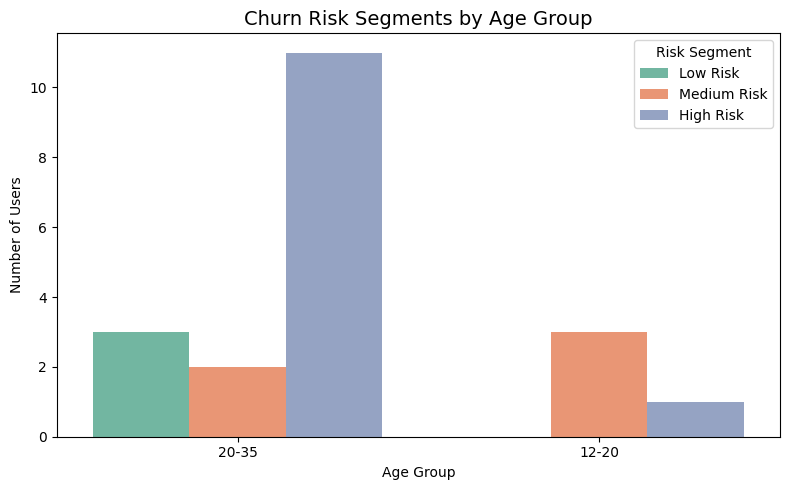

In [ ]:

risk_by_age = churn_risk_df.copy()


age_mapping = encoding_reference[encoding_reference['Column'] == 'age']
age_dict = dict(zip(age_mapping['Encoded Value'], age_mapping['Text Label']))
risk_by_age['age_group'] = X_test['age'].map(age_dict)

plt.figure(figsize=(8, 5))
sns.countplot(data=risk_by_age, x='age_group', hue='risk_segment', palette='Set2')
plt.title("Churn Risk Segments by Age Group", fontsize=14)
plt.xlabel("Age Group")
plt.ylabel("Number of Users")
plt.legend(title="Risk Segment")
plt.tight_layout()
plt.show()


### Churn Risk Segments by Age Group

The bar chart above visualizes how churn risk varies across different age groups in the test data. Each bar represents the number of users in a given age group, segmented by churn risk level (Low, Medium, High).

#### Key Observations:
- **Users aged 20–35 dominate the High Risk segment**, with 11 users predicted as likely to churn. This suggests this age group requires the most proactive retention strategies.
- The same group (20–35) also includes a few Low and Medium risk users, showing diversity in engagement and satisfaction levels.
- **Users aged 12–20 are mostly in the Medium Risk segment**, with no users in Low Risk. This could reflect early-stage or less committed usage patterns among younger users.

#### Business Implications:
- Spotify should **prioritize churn prevention efforts among users aged 20–35**, especially those showing signs of dissatisfaction or disengagement.
- **Younger users (12–20)** may benefit from improved onboarding, personalization, and value communication to increase their loyalty.
- Since this analysis is based on the test set, broader trends should be validated on the full dataset before launching campaigns.



### 2. Risk Segment Heatmap by Preferred Plan Type

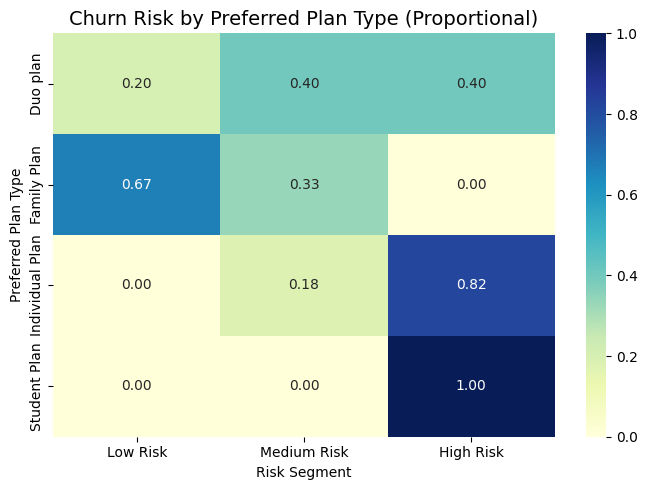

In [ ]:

risk_by_plan = churn_risk_df.copy()

plan_mapping = encoding_reference[encoding_reference['Column'] == 'preferred_plan_type']
plan_dict = dict(zip(plan_mapping['Encoded Value'], plan_mapping['Text Label']))
risk_by_plan['preferred_plan_type'] = X_test['preferred_plan_type'].map(plan_dict)

heatmap_data = pd.crosstab(
    risk_by_plan['preferred_plan_type'],
    risk_by_plan['risk_segment'],
    normalize='index'  
)


plt.figure(figsize=(7, 5))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title("Churn Risk by Preferred Plan Type (Proportional)", fontsize=14)
plt.xlabel("Risk Segment")
plt.ylabel("Preferred Plan Type")
plt.tight_layout()
plt.show()


### Churn Risk by Preferred Plan Type (Proportional Heatmap)

The heatmap above illustrates the **proportion of users in each churn risk segment** (Low, Medium, High) across different Spotify plan preferences.

#### Key Insights:

- **Student Plan users** are at the highest risk:
  - **100% fall under High Risk** suggesting students may be the most price-sensitive or engagement-volatile segment.
  - This indicates a critical need for targeted retention strategies (e.g., student-centric loyalty rewards, subsidized pricing continuity).

- **Individual Plan users** are also highly at risk:
  - **82% are High Risk**, while only 18% fall under Medium Risk.
  - This suggests many individual users may not perceive enough ongoing value or are vulnerable to churn due to price or engagement factors.

- **Duo Plan users** show a more balanced distribution:
  - 40% are High Risk, 40% Medium, and 20% Low Risk.
  - This suggests the Duo plan has some stickiness but still has considerable churn potential.

- **Family Plan users** are the most stable:
  - **67% are Low Risk**, with **no users in High Risk**.
  - Indicates that shared plans likely enhance perceived value and increase retention.

#### Business Recommendations:

- Focus retention efforts on **Student and Individual Plan users**:
  - Improve personalization, deliver perceived value early, and offer continuity discounts before subscription lapses.

- Leverage the **Family Plan’s strong retention** by:
  - Encouraging upgrades from Duo/Individual to Family plans.
  - Offering referral bonuses for expanding household subscriptions.

- For **Duo Plan users**, experiment with engagement nudges and contextual personalization to shift Medium/High Risk users toward loyalty.

This heatmap provides a clear path for **segment-specific churn prevention** based on users’ pricing preferences.
